In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import itertools
import h5py
import keras

C:\Users\Prabodh\Anaconda2\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Split a song into multiple songs using overlapping windows
def splitsongs(X, y, window=0.1, overlap=0.5):
    temp_X = []
    temp_y = []
    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)
    return np.array(temp_X), np.array(temp_y)

In [3]:
def to_melspectrogram(songs, n_fft=1024, hop_length=512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft, hop_length=hop_length)[:,:,np.newaxis]
    # Map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [4]:
def read_data(src_dir, genres, song_samples, spec_format, debug=True):
    arr_specs = []
    arr_genres = []
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                signal = signal[:song_samples]
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                # Convert to dataset of melspectograms
                signals, y = splitsongs(signal, genres[x])
                # Convert to "spec" representation
                specs = spec_format(signals)
                # Save
                arr_genres.extend(y)
                arr_specs.extend(specs)
    return np.array(arr_specs), np.array(arr_genres)

In [5]:
# Parameters
gtzan_dir = 'data/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=False)

In [6]:
np.save('x_gtzan_npy.npy', X)
np.save('y_gtzan_npy.npy', y)

In [7]:
# One hot encoding of labels
from keras.utils import to_categorical
y = to_categorical(y)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13300, 128, 129, 1) (5700, 128, 129, 1) (13300, 10) (5700, 10)


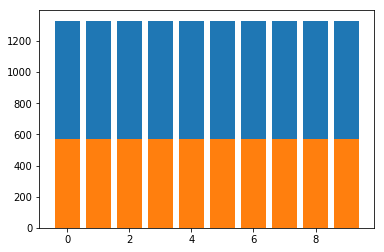

In [10]:
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)
values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import BatchNormalization

In [12]:
# Model definition
input_shape = X_train[0].shape
num_genres = 10
model = Sequential()
# Conv block 1
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
# Conv block 2
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
# Conv block 3
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
# Conv block 4
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
# Conv block 5
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(2, 2)))
model.add(Dropout(0.25))
# MLP
model.add(Flatten())
model.add(Dense(num_genres, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 127, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
__________

In [13]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])
hist = model.fit(X_train, y_train,
                batch_size=32,
                epochs=50,
                verbose=1,
                validation_data=(X_test, y_test))

Train on 13300 samples, validate on 5700 samples
Epoch 1/50
13300/13300 [==============================] - 889s 67ms/step - loss: 2.1151 - acc: 0.2452 - val_loss: 1.7850 - val_acc: 0.3770
Epoch 2/50
13300/13300 [==============================] - 552s 41ms/step - loss: 1.6869 - acc: 0.3970 - val_loss: 1.4900 - val_acc: 0.4695
Epoch 3/50
13300/13300 [==============================] - 429s 32ms/step - loss: 1.5263 - acc: 0.4673 - val_loss: 1.4861 - val_acc: 0.4667
Epoch 4/50
13300/13300 [==============================] - 477s 36ms/step - loss: 1.3859 - acc: 0.5128 - val_loss: 1.3345 - val_acc: 0.5419
Epoch 5/50
13300/13300 [==============================] - 563s 42ms/step - loss: 1.3074 - acc: 0.5441 - val_loss: 1.1861 - val_acc: 0.6047
Epoch 6/50
13300/13300 [==============================] - 664s 50ms/step - loss: 1.2366 - acc: 0.5765 - val_loss: 1.1449 - val_acc: 0.6249
Epoch 7/50
13300/13300 [==============================] - 471s 35ms/step - loss: 1.1740 - acc: 0.5987 - val_loss: 1.0

In [14]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = ", round(score[0], 3)," and val_acc = ", round(score[1], 3))

val_loss =  0.537  and val_acc =  0.822


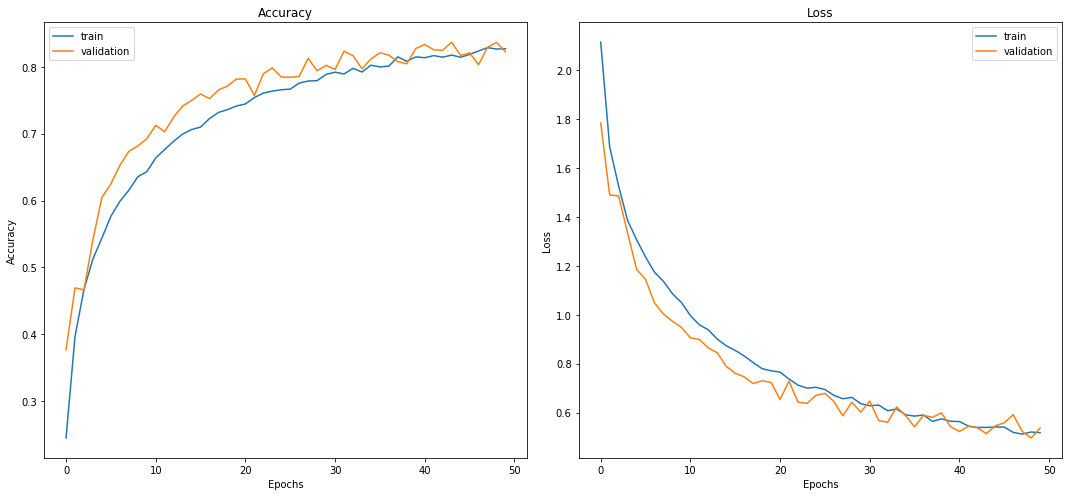

In [15]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
preds = np.argmax(model.predict(X_test), axis=1)
y_orig = np.argmax(y_test, axis=1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


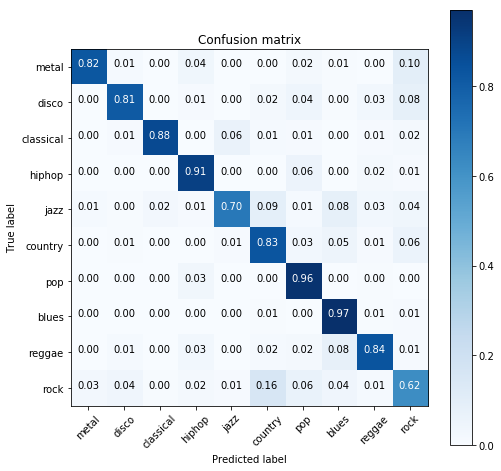

In [21]:
from collections import OrderedDict
keys = OrderedDict(sorted(genres.items(), key = lambda t: t[1])).keys()
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)

In [22]:
# Save model
model.save("model/cnn_2d.h5")